In [1]:
import os
import random
import pandas as pd
import tensorflow as tf

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6



In [3]:
shuffled_folder = 'dataset/shuffled/'
shuffled_files = [shuffled_folder + file for file in os.listdir(shuffled_folder)]
random.shuffle(shuffled_files)

In [5]:
num_files = len(shuffled_files)
training_cut = round(0.4 * num_files)
cross_cut = round(0.7 * num_files)

In [6]:
training_files = shuffled_files[:training_cut]
cross_validation_files = shuffled_files[training_cut:cross_cut]
test_files = shuffled_files[cross_cut:]

In [7]:
def count_rows_in_files(files):
    res = 0
    for file in files:
        df = pd.read_parquet(file)
        res += len(df)
    
    return res

In [8]:
training_rows = count_rows_in_files(training_files)
cross_val_rows = count_rows_in_files(cross_validation_files)
test_rows = count_rows_in_files(test_files)

In [9]:
training_rows, cross_val_rows, test_rows

(126960106, 95696597, 102653243)

In [10]:
total_rows = training_rows + cross_val_rows + test_rows

In [11]:
total_rows

325309946

In [12]:
print(f'training {100 * training_rows / total_rows:.2f}%')
print(f'cross {100 * cross_val_rows / total_rows:.2f}%')
print(f'test {100 * test_rows / total_rows:.2f}%')

training 39.03%
cross 29.42%
test 31.56%


### Base DFs for cross validation

starting with only one df (10 million rows), should be enough to have an idea of the performance of different models, I will escalate later

In [8]:
from sklearn.model_selection import train_test_split

In [10]:
def get_train_test_dfs(file):
    df = pd.read_parquet(file)
    df = df.fillna(0)
    X = df[[i for i in df.columns if not i == 'label']]
    y = df[['label']]
    return train_test_split(X, y, test_size=0.3, stratify=y)

In [96]:
X_train, X_test, y_train, y_test = get_train_test_dfs(training_files[12])

In [97]:
len(X_train)

7000007

In [98]:
len(X_test)

3000003

In [99]:
len(y_train)

7000007

In [100]:
len(y_test)

3000003

In [16]:
def check_distrib(df):
    df = df[['label']]
    ones = len(df[df['label'] == 1])
    return ones / len(df)

just checking the stratify

In [101]:
check_distrib(y_train)

0.7337409805447337

In [102]:
check_distrib(y_test)

0.7337409329257337

### Helper functions

In [103]:
def plot_confusion_matrix(y_true, y_pred):
    conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    conf_mat.plot()

In [104]:
def get_results_from_cv(cv):
    return pd.DataFrame(cv.cv_results_).drop(['params'], axis=1).sort_values('mean_test_score', ascending=False)

In [105]:
def show_feature_importances(estimator, columns):
    return pd.DataFrame(data={'importance': estimator.feature_importances_}, index=columns).sort_values('importance', ascending=False).applymap(lambda v: f'{100 * v:.2f}%')

### Starting with a random forest as control

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [107]:
cv = GridSearchCV(RandomForestClassifier(), {
    'n_estimators': [1, 10, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 10, 100, None]
}, scoring='f1', n_jobs=16, verbose=3, cv=StratifiedKFold())

In [57]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\Lucas\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=16,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 100, None],
                         'n_estimators': [1, 10, 100, 1000]},
             scoring='f1', verbose=3)

In [75]:
get_results_from_cv(cv)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,43.867459,3.240281,1.639186,0.119938,entropy,10,100,0.884714,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
5,5.215665,0.267522,0.339433,0.082126,gini,10,10,0.884715,0.884930,0.884720,0.884480,0.885018,0.884773,0.000188,2
6,40.408750,1.648401,1.468573,0.164781,gini,10,100,0.884715,0.884930,0.884720,0.884480,0.885018,0.884773,0.000188,2
23,382.526772,4.300434,12.294869,0.172509,entropy,10,1000,0.884709,0.884934,0.884720,0.884480,0.885018,0.884772,0.000189,4
30,38.990859,1.193481,1.422491,0.028443,entropy,None,100,0.884709,0.884934,0.884720,0.884480,0.885018,0.884772,0.000189,4
7,390.429645,13.011543,12.899477,0.642416,gini,10,1000,0.884709,0.884934,0.884720,0.884480,0.885018,0.884772,0.000189,4
10,42.922745,1.921866,1.765949,0.270186,gini,100,100,0.884709,0.884930,0.884720,0.884480,0.885018,0.884771,0.000189,7
11,399.425347,12.275884,12.649745,0.378638,gini,100,1000,0.884709,0.884930,0.884720,0.884480,0.885018,0.884771,0.000189,7
13,5.767909,0.608522,0.350185,0.044068,gini,None,10,0.884705,0.884930,0.884720,0.884480,0.885018,0.884771,0.000189,9
26,39.847090,1.374815,1.560764,0.130976,entropy,100,100,0.884705,0.884930,0.884720,0.884480,0.885018,0.884771,0.000189,9


In [63]:
cv.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}

In [58]:
best = cv.best_estimator_
y_pred = best.predict(X_test)

RandomForestClassifier(criterion='entropy', max_depth=10)

---

### Training best params on 10 M rows to check

In [108]:
best = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=100)

In [110]:
best.fit(X_train, y_train)

<ipython-input-110-14230cc6418f>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=10)

In [111]:
y_pred = best.predict(X_test)

F1 = 0.8989334958201576 



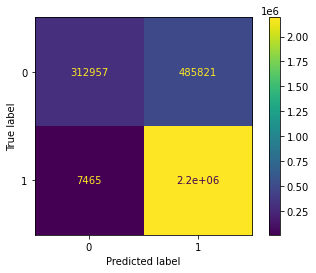

In [112]:
print(f'F1 =', f1_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [113]:
show_feature_importances(best, X_train.columns).head(10)

,importance
duration,80.86%
proto_udp,7.53%
proto_tcp,5.61%
orig_ip_bytes,4.44%
conn_state_s0,0.37%
service_dns,0.33%
conn_state_oth,0.32%
proto_icmp,0.18%
resp_ip_bytes,0.12%
conn_state_rej,0.08%


---

F1 = 0.8850851148492945 



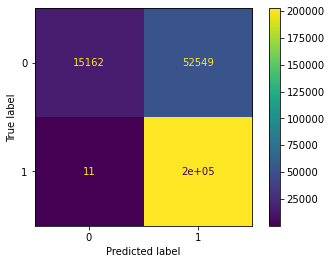

In [111]:
print(f'F1 =', f1_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [95]:
show_feature_importances(best, X_train.columns).head(10)

,importance
duration,67.39%
conn_state_s0,10.29%
resp_pkts,7.37%
resp_ip_bytes,4.10%
proto_tcp,4.04%
proto_udp,2.61%
conn_state_sf,1.12%
proto_icmp,0.64%
service_dns,0.57%
conn_state_s3,0.56%


In [101]:
aux = pd.concat([X_train, y_train], axis=1)[['duration', 'conn_state_s0', 'resp_pkts', 'resp_ip_bytes', 'conn_state_sf', 'label']]
aux

,duration,conn_state_s0,resp_pkts,resp_ip_bytes,conn_state_sf,label
4060710,3.327853e-05,1,0.0,0.0,0,0
5516864,0.000000e+00,1,0.0,0.0,0,1
1535360,0.000000e+00,1,0.0,0.0,0,1
8524678,0.000000e+00,1,0.0,0.0,0,1
5121523,0.000000e+00,1,0.0,0.0,0,1
...,...,...,...,...,...,...
1978437,2.744424e-09,1,0.0,0.0,0,1
2444885,0.000000e+00,1,0.0,0.0,0,1
2354317,0.000000e+00,1,0.0,0.0,0,1
3946927,4.288163e-11,1,0.0,0.0,0,1


In [102]:
aux.corr()

,duration,conn_state_s0,resp_pkts,resp_ip_bytes,conn_state_sf,label
duration,1.000000,-0.057302,0.965244,0.268350,0.000629,-0.010054
conn_state_s0,-0.057302,1.000000,-0.190571,-0.127418,-0.679276,0.035680
resp_pkts,0.965244,-0.190571,1.000000,0.449830,0.081531,-0.005664
resp_ip_bytes,0.268350,-0.127418,0.449830,1.000000,0.129847,-0.000762
conn_state_sf,0.000629,-0.679276,0.081531,0.129847,1.000000,-0.023472
label,-0.010054,0.035680,-0.005664,-0.000762,-0.023472,1.000000


### Gradient Boosting

In [114]:
from sklearn.ensemble import GradientBoostingClassifier

In [117]:
cv = GridSearchCV(GradientBoostingClassifier(verbose=1), {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [1, 10, 100],
    'criterion': ['friedman_mse', 'mse']
}, scoring='f1', n_jobs=16, verbose=3, cv=StratifiedKFold())

In [118]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           1.1226           20.39s
         2           1.1193           19.89s
         3           1.1160           19.75s
         4           1.1129           19.50s
         5           1.1099           19.24s
         6           1.1070           19.01s
         7           1.1042           18.81s
         8           1.1014           18.63s
         9           1.0988           18.40s
        10           1.0963           18.21s
        20           1.0744           16.13s
        30           1.0576           14.10s
        40           1.0441           12.05s
        50           1.0332           10.03s
        60           1.0240            8.02s
        70           1.0164            6.01s
        80           1.0098            4.01s
        90           1.0043            2.00s
       100           0.9994            0.00s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(verbose=1), n_jobs=16,
             param_grid={'criterion': ['friedman_mse', 'mse'],
                         'learning_rate': [0.001, 0.01, 0.1, 0.5],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [1, 10, 100]},
             scoring='f1', verbose=3)

In [119]:
get_results_from_cv(cv)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,12.546955,0.304843,0.356636,0.009651,friedman_mse,0.1,exponential,10,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
46,12.802463,0.192085,0.392200,0.018581,mse,0.5,exponential,10,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
32,105.179619,1.459828,1.114755,0.117892,mse,0.01,deviance,100,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
35,111.243918,1.908517,1.101338,0.035882,mse,0.01,exponential,100,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
22,12.760115,0.309715,0.396205,0.025951,friedman_mse,0.5,exponential,10,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
41,107.572352,1.528137,1.229486,0.135867,mse,0.1,exponential,100,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
8,106.274217,2.040451,1.095689,0.078076,friedman_mse,0.01,deviance,100,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
40,12.848133,0.417106,0.375912,0.020172,mse,0.1,exponential,10,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
11,111.509541,2.791832,1.189197,0.086453,friedman_mse,0.01,exponential,100,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
18,2.417484,0.099380,0.301200,0.015740,friedman_mse,0.5,deviance,1,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1


In [120]:
cv.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.01,
 'loss': 'deviance',
 'n_estimators': 100}

---

### Training best params on 10 M rows

In [115]:
best = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.01, loss='deviance', n_estimators=100)

In [116]:
best.fit(X_train, y_train)

C:\Users\Lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingClassifier(learning_rate=0.01)

In [117]:
y_pred = best.predict(X_test)

F1 = 0.898922754591375 



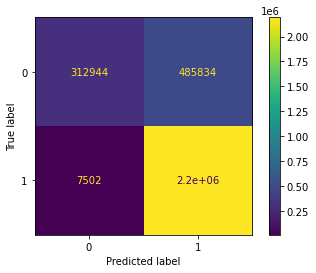

In [118]:
print(f'F1 =', f1_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [119]:
show_feature_importances(best, X_train.columns).head(10)

,importance
duration,94.84%
proto_tcp,2.75%
proto_udp,2.18%
orig_ip_bytes,0.23%
resp_ip_bytes,0.00%
conn_state_s0,0.00%
conn_state_sf,0.00%
conn_state_rej,0.00%
conn_state_rsto,0.00%
conn_state_s1,0.00%


---

In [121]:
best = cv.best_estimator_
y_pred = best.predict(X_test)

F1 = 0.8850831797421418 



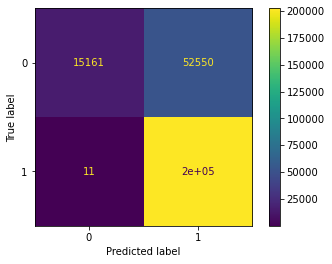

In [122]:
print(f'F1 =', f1_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [123]:
show_feature_importances(best, X_train.columns).head(10)

,importance
duration,99.09%
conn_state_s0,0.72%
proto_tcp,0.07%
proto_udp,0.06%
resp_pkts,0.05%
conn_state_rsto,0.00%
orig_bytes,0.00%
orig_ip_bytes,0.00%
conn_state_oth,0.00%
orig_pkts,0.00%
